# Classification

## Dowloading MNIST Dataset

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

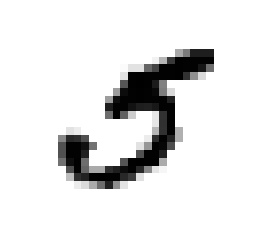

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

## Train set & Test set

In [7]:
# This dataset is split in training set (60000) and test set (10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## Performance Measures

### Measuring Accuracy using Cross-Validation

In [11]:
# Defining my own cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.968
0.8378
0.9384


In [12]:
# Now using cros_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.968 ,  0.8378,  0.9384])

In [13]:
# Demostrating accuracy is not a good scoring measure
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# Above 90% because 10% of the datasets has 5s,so mosy of the time guess no 5s

array([ 0.91015,  0.90765,  0.91115])

### Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[50293,  4286],
       [  830,  4591]])

In [16]:
TN,FP,FN,TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1] # True negative, False positive, False negative, True positive

**Precision:** accuracy of the positive predictions

$ precision = \frac{TP}{TP +TF} $

In [17]:
precision = TP/(TP+FP)
precision

0.51717922721640197

**Recall (sensitivity or true positive rate (TPR)):** ratio of positive instances that are correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [18]:
recall = TP/(TP+FN)
recall

0.84689171739531455

**Precision & Recall** from Sci-kit learn

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) ## Classifier is correct 63% of the time

0.51717922721640197

In [20]:
recall_score(y_train_5, y_train_pred) ## Classifier detects 85% of the 5s

0.84689171739531455

**$F_1$ score**: combine precision & recall, used to compare two classifiers. Use the harmonic mean because a differemce with normal mean, this one gives much more weight to low values. Then, result gets a high $F_1$ score if both precision & recall are high.

$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 * \frac{precision*recall}{precision+recall} = \frac{TP}{TP+\frac{FN+Fp}{2}}$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.64218771856203671

**Precision & recall tradeoff**: increasing precision, reduces recall and vice versa.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
from sklearn.metrics import  precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

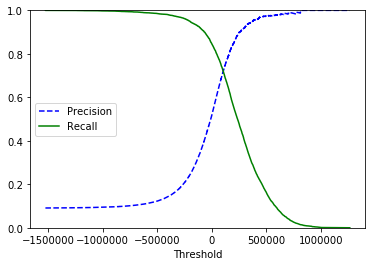

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### The ROC CURVE

The receiver operating characteristic used with binary classifiers, the ROC curve plots _true positive rate_ (recall) against _false positive rate_

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

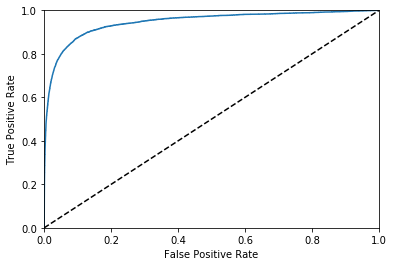

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)

Perfect classifier an area under the curve (ROC AUC) = 1

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.94640717498429794

**Plotting ROC Curve with _RandomForestClassifier_**

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [29]:
y_score_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

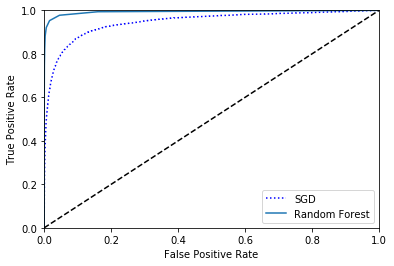

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_score_forest)

0.99310279186601291

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_forest_pred)

0.98280044101433295

In [33]:
recall_score(y_train_5, y_train_forest_pred)

0.82217303080612436

### Multiclass classification

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -38692.76839547, -388367.79282443, -379906.70344492,
        -293959.74410656, -547076.13047442,   76067.66196839,
        -677156.11972045, -213733.34593936, -559175.73271428,
        -610389.63877458]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [39]:
len(ovo_clf.estimators_)

45

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [41]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0.1,  0.2,  0.1,  0.6,  0. ,  0. ,  0. ,  0. ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.85952809,  0.85859293,  0.87328099])

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91111778,  0.90934547,  0.91053658])

### Error Analysis

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5742,    2,   24,    9,    9,   44,   39,   10,   41,    3],
       [   2, 6461,   54,   23,    6,   40,    6,   12,  127,   11],
       [  56,   37, 5343,   99,   80,   25,   97,   56,  149,   16],
       [  48,   41,  139, 5351,    3,  233,   34,   59,  131,   92],
       [  20,   29,   43,    9, 5380,   11,   52,   28,   74,  196],
       [  74,   39,   36,  187,   76, 4620,  102,   29,  164,   94],
       [  40,   19,   54,    2,   41,   88, 5623,    5,   46,    0],
       [  26,   18,   67,   28,   58,   14,    4, 5802,   14,  234],
       [  53,  157,   79,  164,   12,  153,   57,   26, 5002,  148],
       [  40,   34,   28,   88,  156,   34,    2,  204,   67, 5296]])

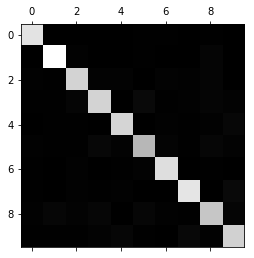

In [45]:
## Image representation of plot matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
conf_mx

array([[5742,    2,   24,    9,    9,   44,   39,   10,   41,    3],
       [   2, 6461,   54,   23,    6,   40,    6,   12,  127,   11],
       [  56,   37, 5343,   99,   80,   25,   97,   56,  149,   16],
       [  48,   41,  139, 5351,    3,  233,   34,   59,  131,   92],
       [  20,   29,   43,    9, 5380,   11,   52,   28,   74,  196],
       [  74,   39,   36,  187,   76, 4620,  102,   29,  164,   94],
       [  40,   19,   54,    2,   41,   88, 5623,    5,   46,    0],
       [  26,   18,   67,   28,   58,   14,    4, 5802,   14,  234],
       [  53,  157,   79,  164,   12,  153,   57,   26, 5002,  148],
       [  40,   34,   28,   88,  156,   34,    2,  204,   67, 5296]])

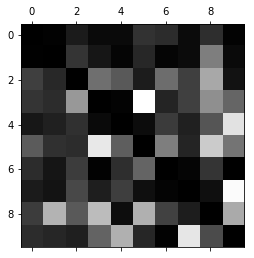

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

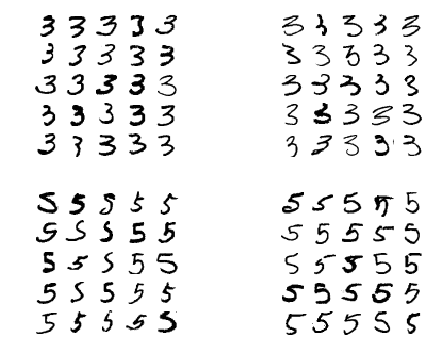

In [48]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 6))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [52]:
f1_score(y_train, y_train_knn_pred, average="macro")

0.96880805300480088

### Multioutput Classification

In [53]:
import numpy.random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')

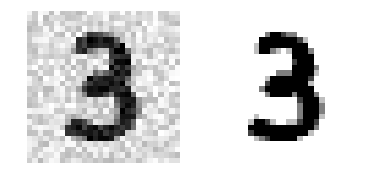

In [68]:
index = 4000
plt.subplot(121); plot_digit(X_test_mod[index])
plt.subplot(122); plot_digit(y_test_mod[index])
plt.show()

In [69]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[index]])

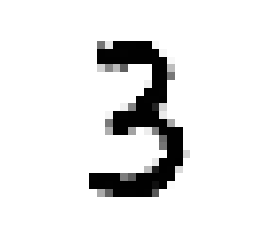

In [70]:
plot_digit(clean_digit)
plt.show()

## Exercises

1. Try to build a classifier for the MINIST dataset that achieves over 97% accuracy on the test set. _Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameters values (try a grid search on the weights and n_neighbors hyperparameters)